In [110]:
import librosa
import utils
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import keras
import time
from PIL import Image
import pathlib
import csv
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report
import warnings
warnings.filterwarnings('ignore')
# from pandas.api.types import CategoricalDtype


In [ ]:
# Extracting the spectrogram for each audio files and saving to an image folder

cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'GTZAN_genres/{g}'):
        songname = f'GTZAN_genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

# Extracting Features from Spectrogram

In [29]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [30]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'GTZAN_genres/{g}'):
        songname = f'GTZAN_genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(librosa.feature.rmse(y=y))} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [86]:
data = pd.read_csv('data.csv')
len(data)

1000

In [87]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
print(data.head())

   chroma_stft      rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.349943  0.130225        1784.420446         2002.650192  3806.485316   
1     0.340983  0.095918        1529.835316         2038.617579  3548.820207   
2     0.363603  0.175573        1552.481958         1747.165985  3040.514948   
3     0.404779  0.141191        1070.119953         1596.333948  2185.028454   
4     0.308590  0.091563        1835.494603         1748.362448  3580.945013   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...    \
0            0.083066 -113.596742  121.557302 -19.158825  42.351029  ...     
1            0.056044 -207.556796  124.006717   8.930562  35.874684  ...     
2            0.076301  -90.754394  140.459907 -29.109965  31.689014  ...     
3            0.033309 -199.431144  150.099218   5.647594  26.871927  ...     
4            0.101500 -160.266031  126.198800 -35.605448  22.153301  ...     

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc1

In [89]:
# Encoding the labels
genre_list = data.iloc[:, -1]
encoder =LabelEncoder()
y = encoder.fit_transform(genre_list)
print(len(y))

1000


In [90]:
# Scaling the feature column
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [91]:
# Splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
class_true = y_test

In [92]:
# x_val = X_train[:200]
# partial_x_train = X_train[200:]

# y_val = y_train[:200]
# partial_y_train = y_train[200:]

# Building the Network

## Artificial Neural Network (ANN)

In [93]:
ANNmodel1 = models.Sequential()
ANNmodel1.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

ANNmodel1.add(layers.Dense(128, activation='relu'))

ANNmodel1.add(layers.Dense(64, activation='relu'))

ANNmodel1.add(layers.Dense(10, activation='softmax'))

In [94]:
ANNmodel1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
# Function to get time taken for each epoch
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()



In [103]:
history = ANNmodel1.fit(
          X_train,
          y_train,
#           partial_x_train,
#           partial_y_train,
          epochs=50,
          batch_size=512,
#           validation_data=(x_val, y_val)
          callbacks=[time_callback]
            )
times = time_callback.times
results = ANNmodel1.evaluate(X_test, y_test)

Epoch 1/50
800/800 [==============================] - 2s 3ms/step - loss: 2.3564 - acc: 0.1488
Epoch 2/50
800/800 [==============================] - 0s 26us/step - loss: 2.1728 - acc: 0.2825
Epoch 3/50
800/800 [==============================] - 0s 19us/step - loss: 2.0317 - acc: 0.3088
Epoch 4/50
800/800 [==============================] - 0s 19us/step - loss: 1.9149 - acc: 0.3438
Epoch 5/50
800/800 [==============================] - 0s 26us/step - loss: 1.8145 - acc: 0.3663
Epoch 6/50
800/800 [==============================] - 0s 22us/step - loss: 1.7192 - acc: 0.3800
Epoch 7/50
800/800 [==============================] - 0s 19us/step - loss: 1.6268 - acc: 0.4050
Epoch 8/50
800/800 [==============================] - 0s 26us/step - loss: 1.5476 - acc: 0.4575
Epoch 9/50
800/800 [==============================] - 0s 20us/step - loss: 1.4737 - acc: 0.5012
Epoch 10/50
800/800 [==============================] - 0s 17us/step - loss: 1.4038 - acc: 0.5437
Epoch 11/50
800/800 [===================

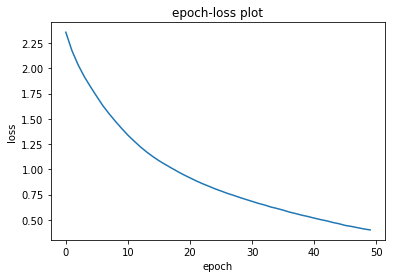

In [104]:
# Epoch - Loss Plot
plt.plot(history.history['loss'])
plt.title('epoch-loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [105]:
results

[1.0840416598320006, 0.64]

In [106]:
#Predictions on Test Data - I am choosing ANNmodel1 from above after comparing performance

predictions = ANNmodel1.predict(X_test)

class_predictions = np.argmax(predictions, axis=-1)
print(len(class_predictions))
print('Predicted Class Labels:',class_predictions)
print('True Class Labels:',class_true)

200
Predicted Class Labels: [7 2 5 3 6 2 2 1 9 2 5 2 2 3 2 3 6 3 1 5 9 5 4 3 5 9 7 9 5 2 5 5 1 6 0 9 4
 0 4 6 1 4 3 3 6 4 0 4 8 6 3 6 8 1 9 6 7 3 8 2 6 4 7 7 0 1 1 5 7 9 8 7 0 3
 9 9 0 1 4 0 7 5 4 2 5 3 1 8 3 4 9 7 2 5 5 2 2 7 3 1 2 8 4 5 9 7 4 2 1 3 4
 9 1 5 6 3 7 1 0 2 7 1 4 9 9 3 5 0 6 5 8 6 3 4 6 4 0 0 1 2 1 3 4 1 2 0 6 7
 7 9 6 3 3 3 5 9 7 4 9 1 3 4 4 0 0 8 1 5 6 9 3 6 5 0 6 9 3 0 7 8 8 1 1 5 7
 1 5 3 6 3 2 3 7 6 4 5 0 1 0 1]
True Class Labels: [7 0 5 7 6 7 2 1 0 2 5 2 2 0 4 3 3 6 1 5 9 7 4 8 0 9 7 2 5 3 5 5 1 0 6 9 4
 0 6 6 1 8 8 3 6 4 0 4 4 6 3 0 2 1 9 6 4 3 8 2 6 4 2 7 0 5 1 5 4 9 4 7 0 3
 9 9 2 1 8 0 7 5 4 2 5 9 5 8 8 4 3 7 2 0 5 2 9 8 3 1 2 2 4 4 2 7 4 2 1 3 6
 9 1 5 6 3 7 1 0 4 8 1 4 5 6 3 1 0 6 2 8 6 3 0 3 7 0 0 1 2 1 3 3 1 9 0 6 8
 7 9 6 3 3 9 8 5 7 6 0 1 8 4 4 0 9 4 1 0 6 6 3 6 5 0 6 4 8 0 8 8 4 1 1 5 5
 1 7 3 6 1 2 4 7 6 6 2 0 1 6 1]


In [107]:
# 10-class confusion matrix
print('Confusion Matrix:\n',confusion_matrix(class_true, class_predictions))

Confusion Matrix:
 [[14  0  1  1  1  3  2  0  0  2]
 [ 0 22  0  1  0  1  0  0  0  0]
 [ 1  0 12  0  0  2  0  1  2  2]
 [ 0  0  1 15  1  0  2  0  0  1]
 [ 0  0  2  1 12  1  0  2  4  1]
 [ 0  2  0  0  0 13  0  1  0  2]
 [ 2  0  0  1  4  0 16  0  0  2]
 [ 0  0  1  1  1  2  0 11  0  0]
 [ 0  0  0  5  2  1  0  4  4  0]
 [ 1  0  2  2  0  0  0  0  0  9]]


In [108]:
# classwise accuracy

def per_class_accuracy(y_preds,y_true,class_labels):
    return [np.mean([
        (y_true[pred_idx] == np.round(y_pred)) for pred_idx, y_pred in enumerate(y_preds) 
      if y_true[pred_idx] == int(class_label)
        ]) for class_label in class_labels]

def update_val_history():
    [val_history[class_label].append(np.mean( np.asarray(temp_hist).T[class_idx] )
                             ) for class_idx, class_label in enumerate(class_labels)]

class_labels = ['0','1','2','3', '4','5','6','7', '8','9']
val_history = {class_label:[] for class_label in class_labels}

temp_hist = per_class_accuracy(class_predictions,class_true,class_labels)
update_val_history()
val_history

{'0': [0.5833333333333334],
 '1': [0.9166666666666666],
 '2': [0.6],
 '3': [0.75],
 '4': [0.5217391304347826],
 '5': [0.7222222222222222],
 '6': [0.64],
 '7': [0.6875],
 '8': [0.25],
 '9': [0.6428571428571429]}

In [111]:
# classwise precision, recall and F-1 score
print(classification_report(class_true, class_predictions))

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        24
           1       0.92      0.92      0.92        24
           2       0.63      0.60      0.62        20
           3       0.56      0.75      0.64        20
           4       0.57      0.52      0.55        23
           5       0.57      0.72      0.63        18
           6       0.80      0.64      0.71        25
           7       0.58      0.69      0.63        16
           8       0.40      0.25      0.31        16
           9       0.47      0.64      0.55        14

   micro avg       0.64      0.64      0.64       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.65      0.64      0.64       200

